In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
def mse(Y_true, Y_pred):
    sq_diff = np.array([])
    for (yt, yp) in zip(Y_true, Y_pred):
        sq_diff = np.append(sq_diff, (yp - yt)**2)
    return (1/Y_true.size)*sq_diff.sum()

def Accuracy(expected, predicted):
    correct = np.where(expected == predicted, 1, 0).sum()
    accuracy = correct/expected.size
    gen_error = 1 - accuracy
    return accuracy

def ConfusionMatrix(expected, predicted, p=1):
    # TP occurs when our prediction aligns with actual data, and prediction is p.
    TP = np.where(((predicted == expected) & (p == predicted)), 1, 0).sum()
    # FP occurs when our prediction is incorrect, but prediction is still p.
    FP = np.where(((predicted != expected) & (p == predicted)), 1, 0).sum()
    # TN occurs when our prediction is correct and is not p.
    TN = np.where(((predicted == expected) & (p != predicted)), 1, 0).sum()
    # FN occurs when our prediction is incorrect, and we predict not p.
    FN = np.where(((predicted != expected) & (p != predicted)), 1, 0).sum()
    # Put values into a matrix, return confusion matrix.
    confusion_matrix = np.array([[TP, FP],
                                 [FN, TN]])
    return confusion_matrix

In [3]:
def decision_boundary_support_vectors(svm_clf, X):
    
    xmin, xmax = X.min() - 1, X.max() + 1
    
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_

    # At the decision boundary, w1*x1 + w2*x2 + b = 0
    # => x2 = -(b + w1* x1)/w1
    x1 = np.linspace(xmin, xmax, 100)
    
    decision_boundary = -(b + w[0]*x1)/w[1]

    shifting_factor_for_margin = 1/w[1]
    upper_margin = decision_boundary + shifting_factor_for_margin
    lower_margin = decision_boundary - shifting_factor_for_margin

    svs = svm_clf.support_vectors_.values
    plt.scatter(svs[:, 0], svs[:, 1], s=100, facecolors='g', label="Support Vectors")
    plt.plot(x1, decision_boundary, "k-", linewidth=2)
    plt.plot(x1, upper_margin, "k--", linewidth=2)
    plt.plot(x1, lower_margin, "k--", linewidth=2)

In [4]:
def sFold(folds, data, labels, model, error_function, **model_args):
    # Check for kwargs which must be inputted manually into KNN_Classifier.
    C = model_args.pop('C', 1)
    max_iter = model_args.pop('max_iter', 100)
    tol = model_args.pop('tol', None)
    learning_rate = model_args.pop('learning_rate', 'constant')
    learning_rate_init = model_args.pop('learning_rate_init', 0.001)
    t_0 = model_args.pop('t_0', 1)
    t_1 = model_args.pop('t_1', 1000)
    early_stopping = model_args.pop('early_stopping', False)
    validation_fraction = model_args.pop('validation_fraction', 0.1)
    
    def s_partition(folds, data, labels):
        parts = {}
        rng = np.random.randint(0, folds, size=labels.size)
        for s in range(folds):
            parts[s] = (data.loc[rng == s], labels.loc[rng == s])
        return parts
    
    # Split data.
    parts = s_partition(folds, data, labels)

    # Initialize output dictionary.
    output = {'expected': np.array([]), 'predicted': np.array([]), 'average error': np.nan}
    # Run through each partition, isolating them one-by-one.
    for iso in parts:
        # Need to copy dict to drop the isolated part.
        without_iso = parts.copy()
        without_iso.pop(iso)
        # Need to accumulate all the data for non-isolated parts.
        data_wo_iso = pd.DataFrame()
        labels_wo_iso = pd.Series()
        for part in without_iso:
            data_wo_iso = pd.concat((data_wo_iso, without_iso[part][0]), axis=0)
            labels_wo_iso = pd.concat((labels_wo_iso, without_iso[part][1]), axis=0)
        model_class = model(C=C, max_iter=max_iter, tol=tol, learning_rate=learning_rate, learning_rate_init=learning_rate_init, t_0=t_0, t_1=t_1, early_stopping=early_stopping, validation_fraction=validation_fraction)
        # Make our knn model, fit it to the accumulated, non-isolated parts.
        model_class.fit(X=data_wo_iso, Y=labels_wo_iso)
        # Prediction of current partition. Actual target is parts[iso][1].
        predicted = model_class.predict(parts[iso][0])
        expected = parts[iso][1]
        # Calculate the error for this run.
        # Store everything in the output dict. Label dict by isolated part.
        output['expected'] = np.concatenate((output['expected'], expected[0]), axis=0)
        output['predicted'] = np.concatenate((output['predicted'], predicted[:, 0]), axis=0)
    # Get error across all partition predictions.
    output['average error'] = error_function(output['expected'], output['predicted'])
    return output

In [5]:
class Linear_SVC():
    def __init__(self, C=1, max_iter=100, tol=None, learning_rate='constant', learning_rate_init=0.001, 
                 t_0=1, t_1=1000, early_stopping=False, validation_fraction=0.1, **kwargs):
        
        self.C = C
        self.max_iter = max_iter
        self.tol = tol
        
        self.learning_rate = learning_rate
        self.learning_rate_init = learning_rate_init
        
        self.t_0 = t_0
        self.t_1 = t_1
        
        if self.learning_rate == 'constant':
            self.eta = self.learning_rate_init
        elif self.learning_rate == 'adaptive':
            self.eta = self.t_0/self.t_1

        
        self.early_stopping = early_stopping
        self.validation_fraction = validation_fraction
        
    def fit(self, X, Y):
        # Convert df to np array
        Y = Y.to_numpy()
        w = np.empty(shape=(1, 2))
        b = 0
        Js = np.empty(shape=(self.max_iter))

        for i in range(self.max_iter):
            w_unscaled = w/X.std().values
            b_unscaled = b - (X.mean().values/X.std().values).dot(w_unscaled.T)
            
            # Compute support vectors. Support vectors are those within the margins at 1: |X| < 1.
            t = Y * 2 - 1
            sv_ineq = t * (np.dot(X, w_unscaled.T) + b_unscaled)
            X_sv = X[np.abs(sv_ineq) <= 1]
            t_sv = t[np.abs(sv_ineq) <= 1]
            
            # ** Make sure sums are correct **
            J = (1/2)*np.dot(w, w.T) + self.C * ((1 - np.dot(X_sv, w.T)).sum() - b * t_sv.sum())
            Js[i] = J
            
            J_delw = w - self.C * X_sv.sum(axis=0).values
            J_delb = -self.C * t_sv.sum()

            w = w - self.eta * J_delw
            b = b - self.eta * J_delb
            
            if self.learning_rate == 'adapative':
                self.eta = self.t_0/(i + self.t_1)
            
            error = mse(Y, np.where(np.sign(np.dot(X, w.T) + b) > 0, 1, 0))
            if isinstance(self.tol, float) and (error < self.tol):
                print('Iterations before Termination:', i)
                break
            
            if i==self.max_iter-1:
                print('Iterations before Termination:', i+1)
                
        self.intercept_ = b
        self.coef_ = w
        self.support_vectors_ = X_sv
        self.J = Js
        
    def predict(self, X):
        return np.where(np.sign(X.dot(self.coef_.T) + self.intercept_) > 0, 1, 0)

In [6]:
def partition(feature_matrix, target_vector, t):
    # Generate a random range of values between 0 and 1.
    rng = np.random.random(target_vector.size)
    # If the number generated above is > t, put in training, else put in test.
    rng_over_t = np.where(rng > t, True, False)
    # Apply mask to features.
    train_features = feature_matrix[rng_over_t]
    test_features = feature_matrix[~rng_over_t]
    # Apply mask to target.
    train_target = target_vector[rng_over_t]
    test_target = target_vector[~rng_over_t]
    return train_features, test_features, train_target, test_target

In [7]:
from sklearn.datasets import load_iris
iris = load_iris()
df2 = pd.DataFrame(iris.data, columns=['sepal length', 'sepal width', 'petal length', 'petal width'])
df2['target'] = iris.target
df2

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [8]:
data = df2[['petal length', 'petal width']]

# Normalizing. Play with this later?
for feature in data.columns:
    data[feature] = (data[feature] - data[feature].mean())/data[feature].std()

# Virginica is index 2 by default, recode it to 1 and others to 0.
target = np.where(df2['target'] == 2, 1, 0)
data, target

C:\Users\MatAdamec\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(     petal length  petal width
 0       -1.335752    -1.311052
 1       -1.335752    -1.311052
 2       -1.392399    -1.311052
 3       -1.279104    -1.311052
 4       -1.335752    -1.311052
 ..            ...          ...
 145      0.816859     1.443994
 146      0.703564     0.919223
 147      0.816859     1.050416
 148      0.930154     1.443994
 149      0.760211     0.788031
 
 [150 rows x 2 columns],
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [9]:
train_X, test_X, train_y, test_y = partition(data, target, 0.2)

In [10]:
train_y = pd.DataFrame(train_y)
test_y = pd.DataFrame(test_y)

In [11]:
model_tests = {'C1_max100_lrconst_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=100, tol=0.1, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.1_max100_lrconst_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=100, tol=0.1, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.01_max100_lrconst_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=100, tol=0.1, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.001_max100_lrconst_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=100, tol=0.1, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C1_max1000_lrconst_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=1000, tol=0.1, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.1_max1000_lrconst_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=1000, tol=0.1, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.01_max1000_lrconst_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=1000, tol=0.1, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.001_max1000_lrconst_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=1000, tol=0.1, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C1_max10000_lrconst_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=10000, tol=0.1, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.1_max10000_lrconst_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=10000, tol=0.1, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.01_max10000_lrconst_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=10000, tol=0.1, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.001_max10000_lrconst_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=10000, tol=0.1, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C1_max100_lradapt_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=100, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.1_max100_lradapt_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=100, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.01_max100_lradapt_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=100, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.001_max100_lradapt_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=100, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C1_max1000_lradapt_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=1000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.1_max1000_lradapt_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=1000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.01_max1000_lradapt_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=1000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.001_max1000_lradapt_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=1000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C1_max10000_lradapt_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=10000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.1_max10000_lradapt_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=10000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.01_max10000_lradapt_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=10000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.001_max10000_lradapt_eta0.001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=10000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C1_max100_lrconst_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=100, tol=0.1, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.1_max100_lrconst_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=100, tol=0.1, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.01_max100_lrconst_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=100, tol=0.1, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.001_max100_lrconst_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=100, tol=0.1, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C1_max1000_lrconst_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=1000, tol=0.1, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.1_max1000_lrconst_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=1000, tol=0.1, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.01_max1000_lrconst_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=1000, tol=0.1, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.001_max1000_lrconst_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=1000, tol=0.1, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C1_max10000_lrconst_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=10000, tol=0.1, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.1_max10000_lrconst_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=10000, tol=0.1, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.01_max10000_lrconst_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=10000, tol=0.1, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.001_max10000_lrconst_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=10000, tol=0.1, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C1_max100_lradapt_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=100, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.1_max100_lradapt_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=100, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.01_max100_lradapt_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=100, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.001_max100_lradapt_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=100, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C1_max1000_lradapt_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=1000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.1_max1000_lradapt_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=1000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.01_max1000_lradapt_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=1000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.001_max1000_lradapt_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=1000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C1_max10000_lradapt_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=10000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.1_max10000_lradapt_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=10000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.01_max10000_lradapt_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=10000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.001_max10000_lradapt_eta0.0001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=10000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C1_max100_lrconst_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=100, tol=0.1, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.1_max100_lrconst_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=100, tol=0.1, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.01_max100_lrconst_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=100, tol=0.1, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.001_max100_lrconst_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=100, tol=0.1, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C1_max1000_lrconst_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=1000, tol=0.1, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.1_max1000_lrconst_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=1000, tol=0.1, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.01_max1000_lrconst_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=1000, tol=0.1, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.001_max1000_lrconst_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=1000, tol=0.1, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C1_max10000_lrconst_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=10000, tol=0.1, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.1_max10000_lrconst_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=10000, tol=0.1, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.01_max10000_lrconst_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=10000, tol=0.1, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.001_max10000_lrconst_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=10000, tol=0.1, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C1_max100_lradapt_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=100, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.1_max100_lradapt_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=100, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.01_max100_lradapt_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=100, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.001_max100_lradapt_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=100, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C1_max1000_lradapt_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=1000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.1_max1000_lradapt_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=1000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.01_max1000_lradapt_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=1000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.001_max1000_lradapt_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=1000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C1_max10000_lradapt_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=10000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.1_max10000_lradapt_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=10000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.01_max10000_lradapt_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=10000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.001_max10000_lradapt_eta0.00001_tol0.1': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=10000, tol=0.1, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C1_max100_lrconst_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=100, tol=0.05, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.1_max100_lrconst_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=100, tol=0.05, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.01_max100_lrconst_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=100, tol=0.05, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.001_max100_lrconst_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=100, tol=0.05, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C1_max1000_lrconst_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=1000, tol=0.05, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.1_max1000_lrconst_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=1000, tol=0.05, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.01_max1000_lrconst_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=1000, tol=0.05, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.001_max1000_lrconst_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=1000, tol=0.05, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C1_max10000_lrconst_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=10000, tol=0.05, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.1_max10000_lrconst_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=10000, tol=0.05, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.01_max10000_lrconst_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=10000, tol=0.05, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.001_max10000_lrconst_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=10000, tol=0.05, learning_rate='constant', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C1_max100_lradapt_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=100, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.1_max100_lradapt_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=100, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.01_max100_lradapt_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=100, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.001_max100_lradapt_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=100, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C1_max1000_lradapt_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=1000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.1_max1000_lradapt_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=1000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.01_max1000_lradapt_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=1000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.001_max1000_lradapt_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=1000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C1_max10000_lradapt_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=10000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.1_max10000_lradapt_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=10000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.01_max10000_lradapt_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=10000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C0.001_max10000_lradapt_eta0.001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=10000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=1000),
              'C1_max100_lrconst_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=100, tol=0.05, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.1_max100_lrconst_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=100, tol=0.05, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.01_max100_lrconst_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=100, tol=0.05, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.001_max100_lrconst_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=100, tol=0.05, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C1_max1000_lrconst_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=1000, tol=0.05, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.1_max1000_lrconst_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=1000, tol=0.05, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.01_max1000_lrconst_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=1000, tol=0.05, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.001_max1000_lrconst_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=1000, tol=0.05, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C1_max10000_lrconst_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=10000, tol=0.05, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.1_max10000_lrconst_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=10000, tol=0.05, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.01_max10000_lrconst_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=10000, tol=0.05, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C0.001_max10000_lrconst_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=10000, tol=0.05, learning_rate='constant', learning_rate_init=0.0001, t_0=1, t_1=1000),
              'C1_max100_lradapt_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=100, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.1_max100_lradapt_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=100, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.01_max100_lradapt_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=100, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.001_max100_lradapt_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=100, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C1_max1000_lradapt_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=1000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.1_max1000_lradapt_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=1000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.01_max1000_lradapt_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=1000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.001_max1000_lradapt_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=1000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C1_max10000_lradapt_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=10000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.1_max10000_lradapt_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=10000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.01_max10000_lradapt_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=10000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C0.001_max10000_lradapt_eta0.0001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=10000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=10000),
              'C1_max100_lrconst_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=100, tol=0.05, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.1_max100_lrconst_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=100, tol=0.05, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.01_max100_lrconst_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=100, tol=0.05, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.001_max100_lrconst_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=100, tol=0.05, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C1_max1000_lrconst_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=1000, tol=0.05, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.1_max1000_lrconst_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=1000, tol=0.05, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.01_max1000_lrconst_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=1000, tol=0.05, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.001_max1000_lrconst_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=1000, tol=0.05, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C1_max10000_lrconst_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=10000, tol=0.05, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.1_max10000_lrconst_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=10000, tol=0.05, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.01_max10000_lrconst_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=10000, tol=0.05, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C0.001_max10000_lrconst_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=10000, tol=0.05, learning_rate='constant', learning_rate_init=0.00001, t_0=1, t_1=1000),
              'C1_max100_lradapt_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=100, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.1_max100_lradapt_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=100, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.01_max100_lradapt_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=100, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.001_max100_lradapt_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=100, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C1_max1000_lradapt_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=1000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.1_max1000_lradapt_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=1000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.01_max1000_lradapt_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=1000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.001_max1000_lradapt_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=1000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C1_max10000_lradapt_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=1, max_iter=10000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.1_max10000_lradapt_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.1, max_iter=10000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.01_max10000_lradapt_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.01, max_iter=10000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000),
              'C0.001_max10000_lradapt_eta0.00001_tol0.05': sFold(4, train_X, train_y, Linear_SVC, Accuracy, C=0.001, max_iter=10000, tol=0.05, learning_rate='adaptive', learning_rate_init=0.001, t_0=1, t_1=100000)
              }
model_tests

C:\Users\MatAdamec\anaconda3\lib\site-packages\ipykernel_launcher.py:32: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Iterations before Termination: 100
Iterations before Termination: 36
Iterations before Termination: 26
Iterations before Termination: 26
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 40
Iterations before Termination: 22
Iterations before Termination: 1000
Iterations before Termination: 20
Iterations before Termination: 342
Iterations before Termination: 1000
Iterations before Termination: 277
Iterations before Termination: 358
Iterations before Termination: 1000
Iterations before Termination: 0
Iterations before Termination: 1000
Iterations before Termination: 1000
Iterations before Termi

Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 1000
Iterations before Termination: 1000
Iterations before Termination: 1000

Iterations before Termination: 1000
Iterations before Termination: 1000
Iterations before Termination: 1000
Iterations before Termination: 259
Iterations before Termination: 10000
Iterations before Termination: 330
Iterations before Termination: 289
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 0
Iterations before Termination: 4012
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 10000
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 100
Iterations before Termination: 

{'C1_max100_lrconst_eta0.001_tol0.1': {'expected': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.]),
  'predicted': array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [12]:
# Find the best model.
best_model_params = (None, np.inf)
for key in model_tests:
    if model_tests[key]['average error'] < best_model_params[1]:
        best_model_params = (key, model_tests[key]['average error'])
print(best_model_params)

('C0.1_max10000_lradapt_eta0.0001_tol0.05', 0.632)


Best model is C=0.1, max_iter=10000, adaptive learning, t_0=1, t_1=10000, tol=0.001

In [13]:
best_model = Linear_SVC(C=0.1, max_iter=10000, tol=0.001, learning_rate='adaptive', t_0=1, t_1=10000)
best_model.fit(train_X, train_y)
preds = best_model.predict(test_X)
acc = Accuracy(test_y.values, preds)
cm = ConfusionMatrix(test_y.values, preds)
print('Preds:', preds.T, '\nReals:', test_y.values.T, '\nAccuracy:', acc, '\nConfusion Matrix:', cm)

Iterations before Termination: 10000
Preds: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]] 
Reals: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]] 
Accuracy: 1.0 
Confusion Matrix: [[ 8  0]
 [ 0 17]]


Text(0, 0.5, 'cost function (J)')

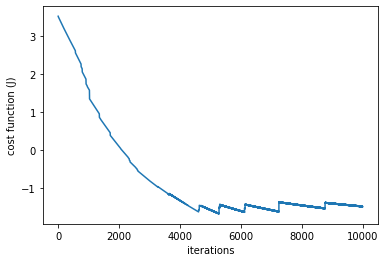

In [14]:
plt.plot(best_model.J), best_model.J
plt.xlabel("iterations")
plt.ylabel("cost function (J)")

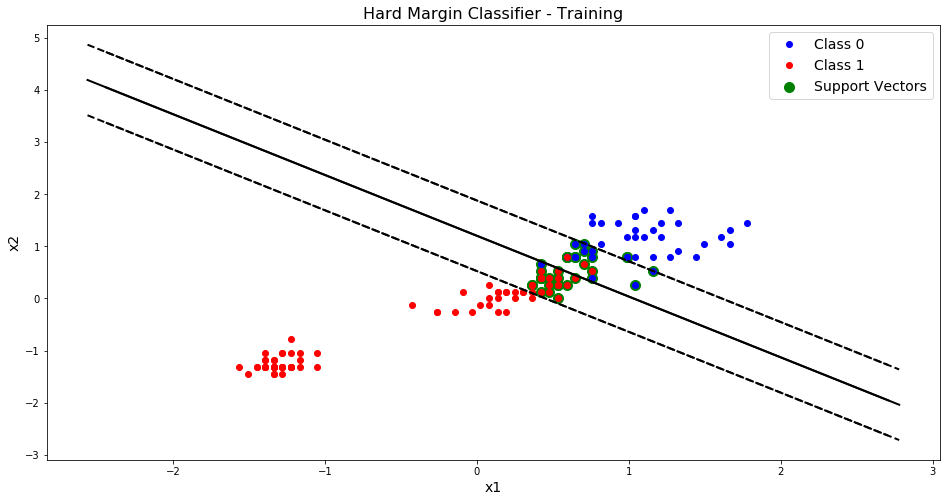

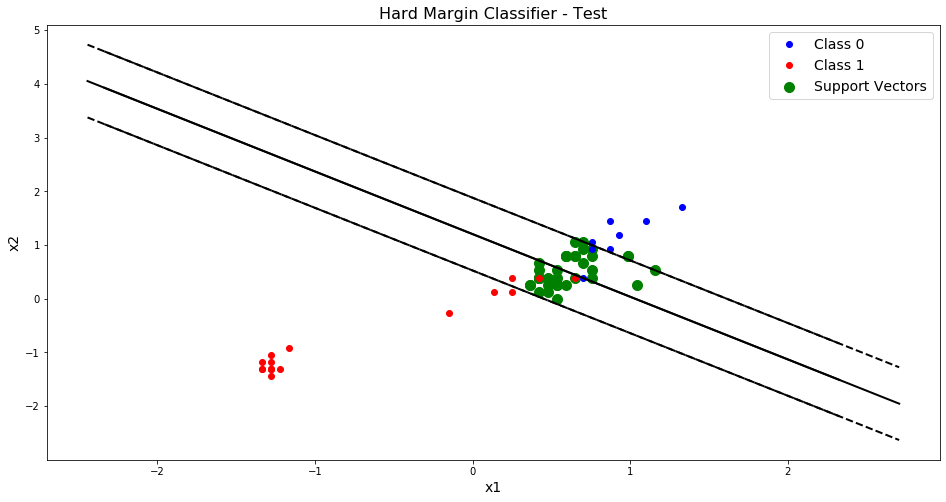

In [15]:
plt.figure(figsize=(16,8))
plt.plot(train_X.values[:, 0][train_y[0]==1], train_X.values[:, 1][train_y[0]==1], "bo", label="Class 0")
plt.plot(train_X.values[:, 0][train_y[0]==0], train_X.values[:, 1][train_y[0]==0], "ro", label="Class 1")

decision_boundary_support_vectors(best_model, train_X)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("Hard Margin Classifier - Training", fontsize=16)
plt.show()

plt.figure(figsize=(16,8))
plt.plot(test_X.values[:, 0][test_y[0]==1], test_X.values[:, 1][test_y[0]==1], "bo", label="Class 0")
plt.plot(test_X.values[:, 0][test_y[0]==0], test_X.values[:, 1][test_y[0]==0], "ro", label="Class 1")

decision_boundary_support_vectors(best_model, test_X)

plt.xlabel("x1", fontsize=14)
plt.ylabel("x2", fontsize=14)
plt.legend(loc="best", fontsize=14)
plt.title("Hard Margin Classifier - Test", fontsize=16)
plt.show()

# PART B

(<matplotlib.image.AxesImage at 0x247d947ea08>,
 array([[ 94,  89,  87, ..., 132, 133, 136],
        [ 96,  89,  84, ..., 137, 137, 140],
        [101,  89,  84, ..., 141, 141, 143],
        ...,
        [234, 234, 235, ..., 148, 150, 151],
        [230, 231, 232, ..., 145, 147, 149],
        [229, 229, 231, ..., 145, 147, 148]], dtype=uint8))

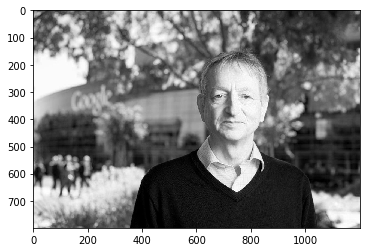

In [16]:
from matplotlib import pyplot as plt
X = plt.imread("Hinton.jpg")[:,:,0]
plt.gray()
plt.imshow(X), X

In [17]:
X_mean = np.mean(X, axis=0)
X = X - X_mean
X

array([[-87.6620776 , -92.38673342, -93.83854819, ...,  20.60075094,
         21.40675845,  24.27158949],
       [-85.6620776 , -92.38673342, -96.83854819, ...,  25.60075094,
         25.40675845,  28.27158949],
       [-80.6620776 , -92.38673342, -96.83854819, ...,  29.60075094,
         29.40675845,  31.27158949],
       ...,
       [ 52.3379224 ,  52.61326658,  54.16145181, ...,  36.60075094,
         38.40675845,  39.27158949],
       [ 48.3379224 ,  49.61326658,  51.16145181, ...,  33.60075094,
         35.40675845,  37.27158949],
       [ 47.3379224 ,  47.61326658,  50.16145181, ...,  33.60075094,
         35.40675845,  36.27158949]])

In [18]:
cov_X = np.dot(X.T, X)/(X.shape[0]-1)
cov_X.shape, cov_X, np.cov(X.T)

((1200, 1200),
 array([[3519.63002625, 3519.5218271 , 3520.36642608, ..., 2318.73784116,
         2290.33480604, 2274.10986321],
        [3519.5218271 , 3530.67355811, 3546.06001079, ..., 2362.4043008 ,
         2335.863018  , 2320.31193127],
        [3520.36642608, 3546.06001079, 3583.96011619, ..., 2443.40915179,
         2419.18487238, 2404.55133453],
        ...,
        [2318.73784116, 2362.4043008 , 2443.40915179, ..., 5383.34541297,
         5359.1763859 , 5333.29528452],
        [2290.33480604, 2335.863018  , 2419.18487238, ..., 5359.1763859 ,
         5345.18647056, 5325.97209701],
        [2274.10986321, 2320.31193127, 2404.55133453, ..., 5333.29528452,
         5325.97209701, 5312.61912917]]),
 array([[3519.63002625, 3519.5218271 , 3520.36642608, ..., 2318.73784116,
         2290.33480604, 2274.10986321],
        [3519.5218271 , 3530.67355811, 3546.06001079, ..., 2362.4043008 ,
         2335.863018  , 2320.31193127],
        [3520.36642608, 3546.06001079, 3583.96011619, ...,

In [19]:
eigen_val, eigen_vec = np.linalg.eig(cov_X)
eigen_vec = np.real(eigen_vec)
eigen_val = np.real(eigen_val)
eigen_vec, eigen_val

(array([[ 0.02019111, -0.02932699,  0.0289205 , ..., -0.0033575 ,
         -0.0033575 ,  0.00328404],
        [ 0.02080031, -0.03007012,  0.02883148, ..., -0.00162579,
         -0.00162579,  0.0012928 ],
        [ 0.02173278, -0.0313064 ,  0.02883498, ...,  0.00343956,
          0.00343956,  0.0002224 ],
        ...,
        [ 0.03602683, -0.03291238,  0.00995045, ...,  0.0421433 ,
          0.0421433 , -0.00534729],
        [ 0.03591972, -0.03251866,  0.00983604, ..., -0.03236349,
         -0.03236349,  0.02561592],
        [ 0.03582182, -0.03224717,  0.00988863, ...,  0.00258099,
          0.00258099, -0.00146478]]),
 array([ 1.66905162e+06,  1.17869670e+06,  6.15459101e+05, ...,
        -4.24660152e-13, -4.24660152e-13, -1.22872085e-12]))

In [20]:
from sklearn.metrics import mean_squared_error

def PCA(eigen_vec, eigen_val, k):
    # We want to get indices of the k top eigenvalues. Argsort does this, with maxes at the end, so we iterate backwards.
    indices = eigen_val.argsort()[-k:]
    top_k_eigen_vec, top_k_eigen_val = eigen_vec[:, indices], eigen_val[indices]
    
    X_projected = np.dot(X, top_k_eigen_vec)
    X_reconstructed = np.dot(X_projected, top_k_eigen_vec.T)
    reconstruction_error = mean_squared_error(X, X_reconstructed)
    
    plt.imshow(X_reconstructed)
    plt.show
    print('k:', k, '\nerror:', reconstruction_error)

k: 10 
error: 470.32037728221934


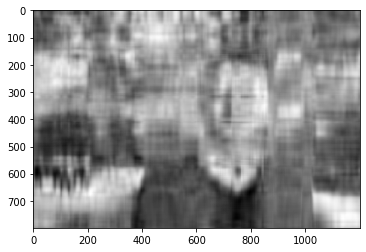

In [21]:
PCA(eigen_vec, eigen_val, 10)

k: 30 
error: 103.82520548230595


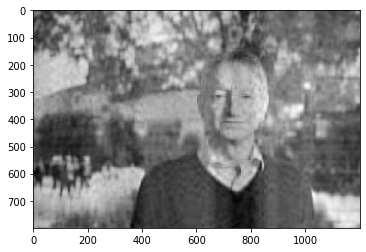

In [22]:
PCA(eigen_vec, eigen_val, 30)

k: 50 
error: 39.176105113242784


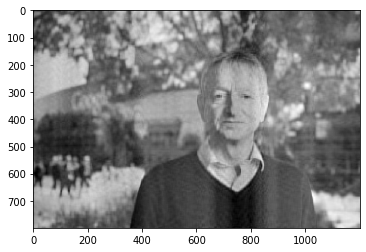

In [23]:
PCA(eigen_vec, eigen_val, 50)

k: 100 
error: 10.189418708196905


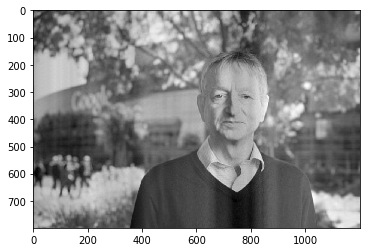

In [24]:
PCA(eigen_vec, eigen_val, 100)

k: 500 
error: 0.05468435288449155


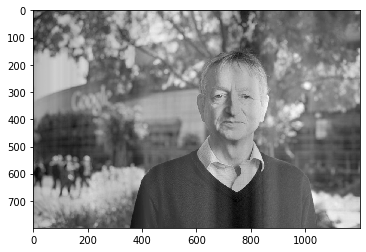

In [25]:
PCA(eigen_vec, eigen_val, 500)